In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
import pickle
import sys
import keras_tuner as kt

### Finding the best model architecture from the grid search

In [3]:
file_path = '/share/rcifdata/jbarr/UKAEAGroupProject/grid_search/'
trainings = []
for i in range(336):
    trial_dict = pickle.load(open(file_path+"trial_"+str(i)+".pkl", 'rb'))
    trainings.append(trial_dict)

In [4]:
# Find the best architecture
best_trial = None 
best_val_acc = - sys.float_info.max

for trial in trainings:
    val_acc = trial["perfomance"][1]
    
    if val_acc > best_val_acc: 
        best_val_acc = val_acc
        best_trial = trial

In [5]:
print("Best Model\n")
print("Network:",best_trial["nodes"],"\n" )
print("Validation accuracy:", best_trial['perfomance'][1])

Best Model

Network: [30 30 30 30] 

Validation accuracy: 0.8433062434196472


Text(0, 0.5, 'Accuracy')

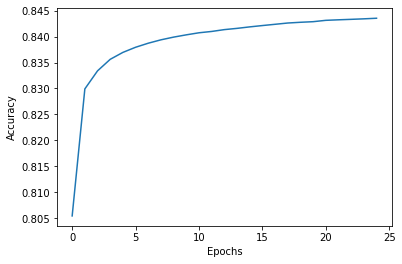

In [6]:
plt.figure()
plt.plot(best_trial["history"]["acc"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'MSE')

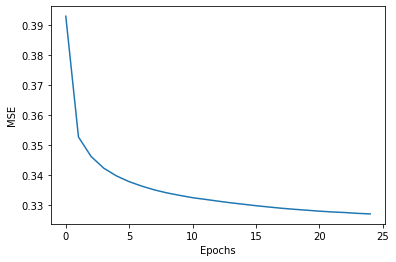

In [7]:
plt.figure()
plt.plot(best_trial["history"]["loss"])
plt.xlabel("Epochs")
plt.ylabel("MSE")

## Hyperparameter optimisation
**Hyperparameters that can be optimised:**
- Learning rate
- Activation function
- Batch size
- 

In [8]:
train_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data.pkl")

X_train, Y_train = train_data.iloc[:,:-1].to_numpy(), train_data.iloc[:,-1].to_numpy()

validation_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/validation_data.pkl")

X_val, Y_val = validation_data.iloc[:,:-1].to_numpy(), validation_data.iloc[:,-1].to_numpy()

In [9]:
# standard scaler
scaler = StandardScaler()
scaler.fit(X_train)
x_train = scaler.transform(X_train)
x_val = scaler.transform (X_val)

In [10]:
def model_builder(hp): 
    model = tf.keras.Sequential()
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_act = hp.Choice('activation', values = ['relu','tanh', 'elu', 'gelu', 'swish'])
    
    model.add(tf.keras.layers.Dense(30, activation=hp_act)),
    model.add(tf.keras.layers.Dense(30, activation=hp_act)),
    model.add(tf.keras.layers.Dense(30, activation=hp_act)), 
    model.add(tf.keras.layers.Dense(30, activation=hp_act)), 
    model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='./',
                     project_name='class_hyperband')

2022-02-01 10:47:14.986643: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-01 10:47:14.987180: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-01 10:47:14.990080: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [13]:
tuner.search(x_train, Y_train, epochs=50, validation_split=0.2,batch_size = 4096, callbacks=[stop_early])

Trial 20 Complete [00h 04m 04s]
val_accuracy: 0.8327795267105103

Best val_accuracy So Far: 0.8417887687683105
Total elapsed time: 01h 09m 35s
INFO:tensorflow:Oracle triggered exit


In [16]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
history = model.fit(x_train, Y_train, epochs=50, validation_split=0.2, batch_size = 4096, callbacks=[stop_early])

Epoch 1/50
5218/5218 [==============================] - 127s 24ms/step - loss: 0.3794 - accuracy: 0.8127 - val_loss: 0.3367 - val_accuracy: 0.8384
Epoch 2/50
5218/5218 [==============================] - 121s 23ms/step - loss: 0.3372 - accuracy: 0.8377 - val_loss: 0.3339 - val_accuracy: 0.8393
Epoch 3/50
5218/5218 [==============================] - 127s 24ms/step - loss: 0.3323 - accuracy: 0.8405 - val_loss: 0.3306 - val_accuracy: 0.8414
Epoch 4/50
5218/5218 [==============================] - 124s 24ms/step - loss: 0.3300 - accuracy: 0.8418 - val_loss: 0.3302 - val_accuracy: 0.8418
Epoch 5/50
5218/5218 [==============================] - 123s 24ms/step - loss: 0.3287 - accuracy: 0.8424 - val_loss: 0.3271 - val_accuracy: 0.8435
Epoch 6/50
5218/5218 [==============================] - 123s 24ms/step - loss: 0.3274 - accuracy: 0.8430 - val_loss: 0.3267 - val_accuracy: 0.8436
Epoch 7/50
5218/5218 [==============================] - 162s 31ms/step - loss: 0.3266 - accuracy: 0.8436 - val_loss: 0